# Project: Image Retrieval using CLIP Model 
### Dataset: 
1. Web Scraped Google Images + Caption from ChatGPT 
2. Google's Conceptual Captioning Dataset Collection

### Notebooks:

* Notebook 1: Dataset Collection
* Notebook 2: Training CLIP Model
* Notebook 3: Evaluation and Inference
* Model Deployment: Docker + FastAPI 

# Importing Libraries

In [1]:
import pandas as pd
!pip install datasets
from datasets import Dataset, load_dataset, load_from_disk, concatenate_datasets
import os
import threading
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPImageProcessor
from transformers import AdamW
import torchvision.transforms as transforms

os.environ["TOKENIZERS_PARALLELISM"] = "true"  # Set to "false" if needed

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
from tqdm import tqdm 
from torch.optim.lr_scheduler import ReduceLROnPlateau

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("SHIRSH_HUGGINGFACE_API_KEY")


from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# Get the number of available processors
num_processors = os.cpu_count()

# Get the number of active threads (including main thread)
num_threads = threading.active_count()

print("Number of available processors:", num_processors)
print("Number of active threads:", num_threads)

Number of available processors: 2
Number of active threads: 7


# Import Data

In [3]:
# os.makedirs("/kaggle/working/Google_Conceptual_Caption_Dataset_Images_Captions", exist_ok=True)

# source_path = "/kaggle/input/image-retrieval-clip-training-conceptual-caption"  # Replace with the actual source file path
# destination_path = "/kaggle/working/Google_Conceptual_Caption_Dataset_Images_Captions"  # Replace with the actual destination folder path

# # filenames = ["/Google_Conceptual_Caption_Dataset_Images_Captions/dataset.arrow", "/Google_Conceptual_Caption_Dataset_Images_Captions/dataset_info.json", "/Google_Conceptual_Caption_Dataset_Images_Captions/state.json"]

# import os; filenames = os.listdir(source_path+"/Google_Conceptual_Caption_Dataset_Images_Captions")

# filenames = [os.path.join(source_path, "Google_Conceptual_Caption_Dataset_Images_Captions/"+file) for file in filenames]

# for file in filenames:
#     # Copy each file from source to destination
#     shutil.copy(file, destination_path)

In [4]:
# # dataset = load_from_disk('/kaggle/working/Google_Conceptual_Caption_Dataset_Images_Captions')
# # dataset = dataset.filter(lambda example, index: example["image_data"].size[0]*example["image_data"].size[1] <= 2048*2048 and ( index<5000 or index>6000 ), with_indices=True) 
# # dataset = dataset.filter(lambda example, index: example["image_data"].size[0]*example["image_data"].size[1] <= 2048*2048 and index<500 , with_indices=True)

dataset = load_dataset("shirsh10mall/Image_Captioning_Dataset", streaming=False)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/shirsh10mall--Image_Captioning_Dataset-104135c265698044/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
dataset = dataset.filter(lambda instance, index: instance["drop_this_row"] == "no" and ( index<7000 or index>8000 ), with_indices=True)
dataset = dataset.remove_columns(["drop_this_row","image_url"])
dataset

  0%|          | 0/175 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['caption', 'image_data'],
        num_rows: 143134
    })
})

In [6]:
# # Save the dataset locally
# dataset.save_to_disk("/kaggle/working/GCC_dataset_144k")
# print("Dataset saved locally.")

# Display few Image-Caption




 Caption:  actor arrives for the premiere of the film


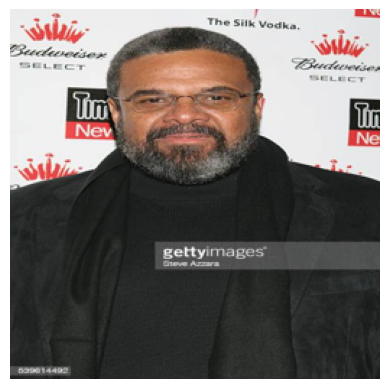




 Caption:  celebrities start decorating for the christmas season lifestyle


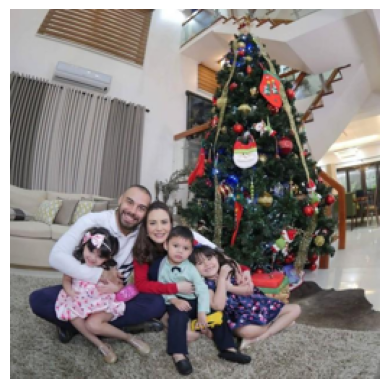




 Caption:  functions of government : 1 . form a more perfect union


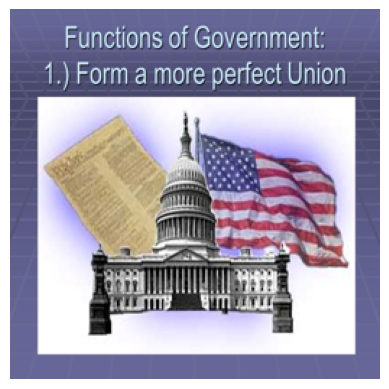




 Caption:  actor attends the premiere of season


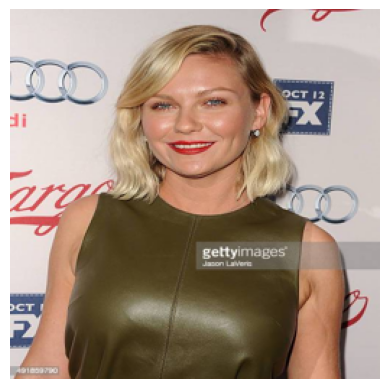




 Caption:  all shots by by person and rider shots can be found on his website .


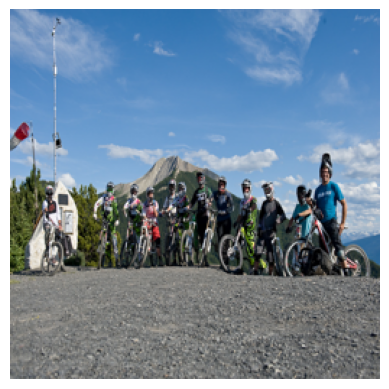

In [7]:
for index in range(10,15):
    # Display the image using matplotlib
    image_array = dataset["train"][index]["image_data"]
    caption = dataset["train"][index]["caption"]
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axes
    print("\n\n\n Caption: ", caption )
    plt.show()

# CLIP Model and Dataloader Setup

In [8]:
# Load pre-trained CLIP model and tokenizer
model_name =  "openai/clip-vit-base-patch16" # "openai/clip-vit-large-patch14" 
# model_name = "shirsh10mall/Fine_Tuned_CLIP_Model"
model = CLIPModel.from_pretrained(model_name)
tokenizer = CLIPProcessor.from_pretrained(model_name)
processor = CLIPImageProcessor.from_pretrained(model_name)

max_length = 22

# Define your dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=64):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transforms.Compose([   transforms.Resize((224,224)) ,  # Resize the PIL image
                                                transforms.ToTensor()  # Convert the PIL image back to tensor
                                            ])
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        instance = self.dataset[idx]
        image = instance["image_data"]
        image = self.transform( image )
        channels = image.shape[0]
        if channels==1:
            image = torch.stack( [image]*3 , dim=1)
        elif channels==4:
            image = image[:3, :, :]
            
        # image = processor(images=image, return_tensors="pt").pixel_values
        
        caption = instance["caption"]
                
        text_inputs = self.tokenizer(caption, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        
        return { 'pixel_values': image.squeeze(), 'input_ids': text_inputs['input_ids'].squeeze(),
                    'attention_mask': text_inputs['attention_mask'].squeeze() }

train_dataset = ImageCaptionDataset(dataset["train"], tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, prefetch_factor=num_processors, num_workers=num_processors,
                                      pin_memory=True, drop_last=True)

In [9]:
# for batch in tqdm(train_dataloader):
#     if batch==-1:
#         print("yo")

In [10]:
# for batch in train_dataloader:
#     print([elem.size() for elem in batch.values()])
#     break
    
# train_dataset.__getitem__(0)["pixel_values"].shape, train_dataset.__getitem__(0)["input_ids"].shape, train_dataset.__getitem__(0)["attention_mask"].shape

# Training Model

In [11]:
# Set up optimizer and scheduler function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Training loop
num_epochs = 8
print_every = 100

# Early Stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0

model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch + 1}")
    
    for batch_idx, batch in pbar:
        
        optimizer.zero_grad()
        
        pixel_values = batch['pixel_values'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, return_loss=True)

        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        loss = outputs.loss
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % print_every == 0:  # Print results after a few batches
            avg_loss = total_loss / (batch_idx + 1)
            pbar.set_postfix({"Average Loss": avg_loss})
            
            
    # Learning rate scheduler step based on validation loss
    scheduler.step(total_loss)
    
    # Early Stopping
    if total_loss < best_val_loss:
        best_val_loss = total_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break
        
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

Epoch 1: 100%|██████████| 17891/17891 [1:05:19<00:00,  4.56it/s, Average Loss=0.147]

Epoch 1/8, Average Loss: 0.1472



Epoch 2: 100%|██████████| 17891/17891 [1:05:33<00:00,  4.55it/s, Average Loss=0.0737]

Epoch 2/8, Average Loss: 0.0738



Epoch 3: 100%|██████████| 17891/17891 [1:05:39<00:00,  4.54it/s, Average Loss=0.0547]

Epoch 3/8, Average Loss: 0.0547



Epoch 4: 100%|██████████| 17891/17891 [1:05:25<00:00,  4.56it/s, Average Loss=0.0449]

Epoch 4/8, Average Loss: 0.0449



Epoch 5: 100%|██████████| 17891/17891 [1:05:19<00:00,  4.56it/s, Average Loss=0.0388]

Epoch 5/8, Average Loss: 0.0388



Epoch 6: 100%|██████████| 17891/17891 [1:05:31<00:00,  4.55it/s, Average Loss=0.0347]

Epoch 6/8, Average Loss: 0.0347



Epoch 7: 100%|██████████| 17891/17891 [1:05:14<00:00,  4.57it/s, Average Loss=0.0306]

Epoch 7/8, Average Loss: 0.0305



Epoch 8: 100%|██████████| 17891/17891 [1:05:28<00:00,  4.55it/s, Average Loss=0.028]

Epoch 8/8, Average Loss: 0.0281


# Saving Model 

In [12]:
model.push_to_hub( "shirsh10mall/Fine_Tuned_CLIP_Model", use_auth_token=secret_value, commit_message="CLIP_model_training_"+model_name+"_epochs"+str(num_epochs)+"_datapoint"+str(len(train_dataset)) )

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shirsh10mall/Fine_Tuned_CLIP_Model/commit/26d6dccfa4118850537d83daee8bb343015e810d', commit_message='CLIP_model_training_openai/clip-vit-base-patch16_epochs8_datapoint143134', commit_description='', oid='26d6dccfa4118850537d83daee8bb343015e810d', pr_url=None, pr_revision=None, pr_num=None)

### Please check the second notebook - Inference , FAISS Indexing and Image Retrieval System